__AIM:__


  - Surprise Housing, a US-based real estate company, has made the decision to join the Australian market. The company buys houses below market value and resells them for a greater price. The company has collected a data set from the sale of houses in Australia.  

  - The goal of the company is:
   
    - To determine factors (like <span style='color:green'>LotFrontage</span>, <span style='color:green'>LotArea</span>, <span style='color:green'>GarageArea</span>) that may influence the house price in the Australian market.

    - To develop a regression model using regularisation based on those factors, that would explain the variations in the house price.

    - To know the R-squared or Mean Squared Error of the model, i.e. how well those factors capture the price of the house.

    - To ascertain the best lambda value for lasso and ridge regression. 

In [1]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PowerTransformer
from scipy import stats
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import r2_score, mean_squared_error
warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:.3f}'.format

In [2]:
house_price_data = pd.read_csv('train.csv', header=0, sep=',')

In [3]:
house_price_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.000,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.000,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.000,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.000,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.000,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
house_price_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

#### Explore common statistics

In [5]:
print('Total number of Columns:',house_price_data.shape[1])
print('Total number of Rows:',house_price_data.shape[0])
print('Total number of missing values:',house_price_data.isna().sum(axis=0).sum())

Total number of Columns: 81
Total number of Rows: 1460
Total number of missing values: 7829


#### Dropping irrelavant column
- **Id** is an identifier; it is not analytically useful factual data. It is therefore droppable.

In [6]:
house_price_data.drop('Id', axis=1, inplace=True)

#### Remove Columns with same values

1) Create a function to detect variables that have same values very often and drop them

In [7]:
def detect_var_same_values(dframe):
    if isinstance(dframe, pd.DataFrame):
        cols_identical_val = [col for col in dframe.keys() if dframe[col].value_counts(normalize=True, dropna=False).iloc[0]>=.99]
        dframe = dframe.drop(cols_identical_val, axis=1)
        print('List of columns removed since majority of their values are identical:\n\n', cols_identical_val)
        return dframe
    else:
        raise TypeError('Pass a DataFrame object')

2) Call the above function to drop the variables with most of the identical values as they will not add any value to the house price prediction

In [8]:
house_price_data = detect_var_same_values(house_price_data)

List of columns removed since majority of their values are identical:

 ['Street', 'Utilities', 'PoolArea', 'PoolQC']


#### Missing values
1) Determine the percentage of missing values in each column

In [9]:
perc_missing = (house_price_data.isna().sum(axis=0)/len(house_price_data)*100).sort_values(ascending=False)
perc_missing[perc_missing>0]

MiscFeature    96.301
Alley          93.767
Fence          80.753
MasVnrType     59.726
FireplaceQu    47.260
LotFrontage    17.740
GarageType      5.548
GarageYrBlt     5.548
GarageQual      5.548
GarageCond      5.548
GarageFinish    5.548
BsmtFinType2    2.603
BsmtExposure    2.603
BsmtQual        2.534
BsmtFinType1    2.534
BsmtCond        2.534
MasVnrArea      0.548
Electrical      0.068
dtype: float64

2) Imputing the missing values of <span style='color:blue'>GarageYrBlt</span> with <span style='color:purple'>**0**</span>, because it will be utilized to derive ```Data Driven Metric``` below. <br><br><span style='color:green'><u>*Note*</u>: Missing values of the remaining variables will be handled later.</span>

In [10]:
house_price_data['GarageYrBlt'] = house_price_data['GarageYrBlt'].replace(np.nan, 0)

#### Derive New Features (<span style='color:purple'>**Data Driven Metrics**</span>)

1) Compute the years went by since the garage was built at the time of the sale.

In [11]:
house_price_data['GarageAge_AtSale'] = house_price_data['YrSold'] - house_price_data['GarageYrBlt']

2) After the property is constructed and renovated, determine its age at the time of sale

In [12]:
house_price_data['HouseAge_AtSale'] = house_price_data['YrSold'] - house_price_data['YearBuilt']
house_price_data['HouseAgeSinceRemodel_AtSale'] = house_price_data['YrSold'] - house_price_data['YearRemodAdd']

3) Compute Total Porch Area in square feet

In [13]:
house_price_data['TotalPorchAreaSF'] = house_price_data['OpenPorchSF'] + house_price_data['3SsnPorch'] + house_price_data['EnclosedPorch'] + house_price_data['ScreenPorch']

4) As we already have **BsmtUnfSF** as Unfinished basement area, let's calculate the Total Basement Finished Area in square feet

In [14]:
house_price_data['TotalBasementFinAreaSF'] = house_price_data['BsmtFinSF1'] + house_price_data['BsmtFinSF2']

5) Derive Total Area of floors in square feet

In [15]:
house_price_data['TotalFloorAreaSF'] = house_price_data['1stFlrSF'] + house_price_data['2ndFlrSF']

#### Drop the variables which are already used to derive the ***Data Driven Metrics*** above

In [16]:
house_price_data.drop(['GarageYrBlt', 'YearBuilt', 'YearRemodAdd', 'BsmtFinSF1', 'BsmtFinSF2', '1stFlrSF', '2ndFlrSF',
                       'OpenPorchSF', '3SsnPorch', 'EnclosedPorch', 'ScreenPorch'],
                      axis=1,
                      inplace=True)

#### Invalid Values<br>

   - Derived column <span style='color:purple'>HouseAgeSinceRemodel_AtSale</span> has **one negative value** which is invalid because the year when the house was remodeled is ***<u>higher</u>*** than the year when the house was built, which is not possible. So, replacing that invalid value with 0 

In [17]:
print('Number of invalid (-ve) values in "HouseAgeSinceRemodel_AtSale" column: ', 
      sum(house_price_data['HouseAgeSinceRemodel_AtSale'] < 0))

Number of invalid (-ve) values in "HouseAgeSinceRemodel_AtSale" column:  1


In [18]:
# Find the -ve value in "HouseAgeSinceRemodel_AtSale" column
print(house_price_data.loc[house_price_data['HouseAgeSinceRemodel_AtSale'] < 0, 'HouseAgeSinceRemodel_AtSale'])

523   -1
Name: HouseAgeSinceRemodel_AtSale, dtype: int64


In [19]:
# Replace the -ve value with 0 in "HouseAgeSinceRemodel_AtSale" column
house_price_data['HouseAgeSinceRemodel_AtSale'] = house_price_data['HouseAgeSinceRemodel_AtSale'].replace(-1, 0)

#### Check for duplicate rows

In [20]:
house_price_data.duplicated().sum()

0

> <span style='color:purple'><u>Interpretation</u></span></ul>: <br>No duplicate rows found in the dataframe.

#### **Univariate Analysis on Quantitative Variables**

In [21]:
# select the numerical columns for the below analysis
num_cols = house_price_data.select_dtypes(exclude = object)

# date related columns 'YrSold', 'MoSold' can be eliminated from this dataframe with numerical columns
num_cols = num_cols.drop(['YrSold', 'MoSold'], axis=1)

In [22]:
num_cols.shape

(1460, 29)

1) Determine the number of unique values in each numerical columns 

In [23]:
num_cols.nunique(axis=0).sort_values(ascending=False)

LotArea                        1073
TotalFloorAreaSF                862
GrLivArea                       861
BsmtUnfSF                       780
TotalBsmtSF                     721
SalePrice                       663
TotalBasementFinAreaSF          637
GarageArea                      441
MasVnrArea                      327
TotalPorchAreaSF                287
WoodDeckSF                      274
HouseAge_AtSale                 122
LotFrontage                     110
GarageAge_AtSale                106
HouseAgeSinceRemodel_AtSale      61
LowQualFinSF                     24
MiscVal                          21
MSSubClass                       15
TotRmsAbvGrd                     12
OverallQual                      10
OverallCond                       9
BedroomAbvGr                      8
GarageCars                        5
Fireplaces                        4
KitchenAbvGr                      4
FullBath                          4
BsmtFullBath                      4
HalfBath                    

2) select <span style='color:green'>top 15 numerical columns</span> with <span style='color:blue'>most number of unique values</span>

In [24]:
top_15_numerical = num_cols.nunique(axis=0).sort_values(ascending=False)[:15]
top_15_numerical

LotArea                        1073
TotalFloorAreaSF                862
GrLivArea                       861
BsmtUnfSF                       780
TotalBsmtSF                     721
SalePrice                       663
TotalBasementFinAreaSF          637
GarageArea                      441
MasVnrArea                      327
TotalPorchAreaSF                287
WoodDeckSF                      274
HouseAge_AtSale                 122
LotFrontage                     110
GarageAge_AtSale                106
HouseAgeSinceRemodel_AtSale      61
dtype: int64

3) Create a function to plot multiple historams using subplots

In [25]:
def plot_multiple_histograms_univar(dframe, colnames_idx):
    '''
    Plot histograms for univariate analysis.

    Params:
      dframe: Dataframe to read
      colnames_idx: Array of column names to access in the dataframe
    '''
    if not isinstance(colnames_idx, np.ndarray):
        raise TypeError('"colnames_idx" must be a numpy array')
    if isinstance(dframe, pd.DataFrame):
        try:
            fig, ax = plt.subplots(nrows=8, ncols=2, sharex=False, sharey=False)
            fig.set_size_inches(11, 25)
            for colnames, axes in zip(colnames_idx, [(0, 0), (0, 1),
                                                     (1, 0), (1, 1),
                                                     (2, 0), (2, 1),
                                                     (3, 0), (3, 1),
                                                     (4, 0), (4, 1),
                                                     (5, 0), (5, 1),
                                                     (6, 0), (6, 1),
                                                     (7, 0), (7, 1)]):
                num, bin, _ = ax[axes[0], axes[1]].hist(x=dframe[colnames], bins=50, edgecolor='red', color='cyan')
                ax_kde= ax[axes[0], axes[1]].twinx()
                sns.kdeplot(dframe[colnames], ax=ax_kde, color='purple')
                ax[axes[0], axes[1]].set_xlabel(colnames, color='red')
                sorted_bins = sorted(zip(np.round(num, 1), zip(np.round(bin[:-1], 1), np.round(bin[1:], 1))),
                                     key=lambda x:x[0],
                                     reverse=True)
                ax[axes[0], axes[1]].set_title(f'most common bin: {sorted_bins[0][1]} \n2nd most common bin: {sorted_bins[1][1]} \nmin: {bin.min().astype(int)},  max: {bin.max().astype(int)} \nskew: {round(dframe[colnames].skew(), 2)},  kurtosis: {round(dframe[colnames].kurtosis(), 2)}',
                                               fontsize=9, fontweight=30, color='black', loc='left')
                ax_kde.set_ylabel('')
                ax_kde.tick_params(labelright=False)
            ax[7, 1].set_axis_off()
            fig.tight_layout()
            fig.suptitle('Frequency Distribution + KDE of numerical columns', fontsize=15, color='blue', x=0.5, y=1.03)
            # fig.supylabel('Frequency', fontsize=15, color='blue', x=0, y=.53)
            fig.show()
        except Exception as e:
            raise e
    else:
        raise TypeError('"dframe" must be a dataframe object')        

2) Plot Histograms to visualize the frequency distribution of those selected <span style='color:blue'>15 numerical columns</span>

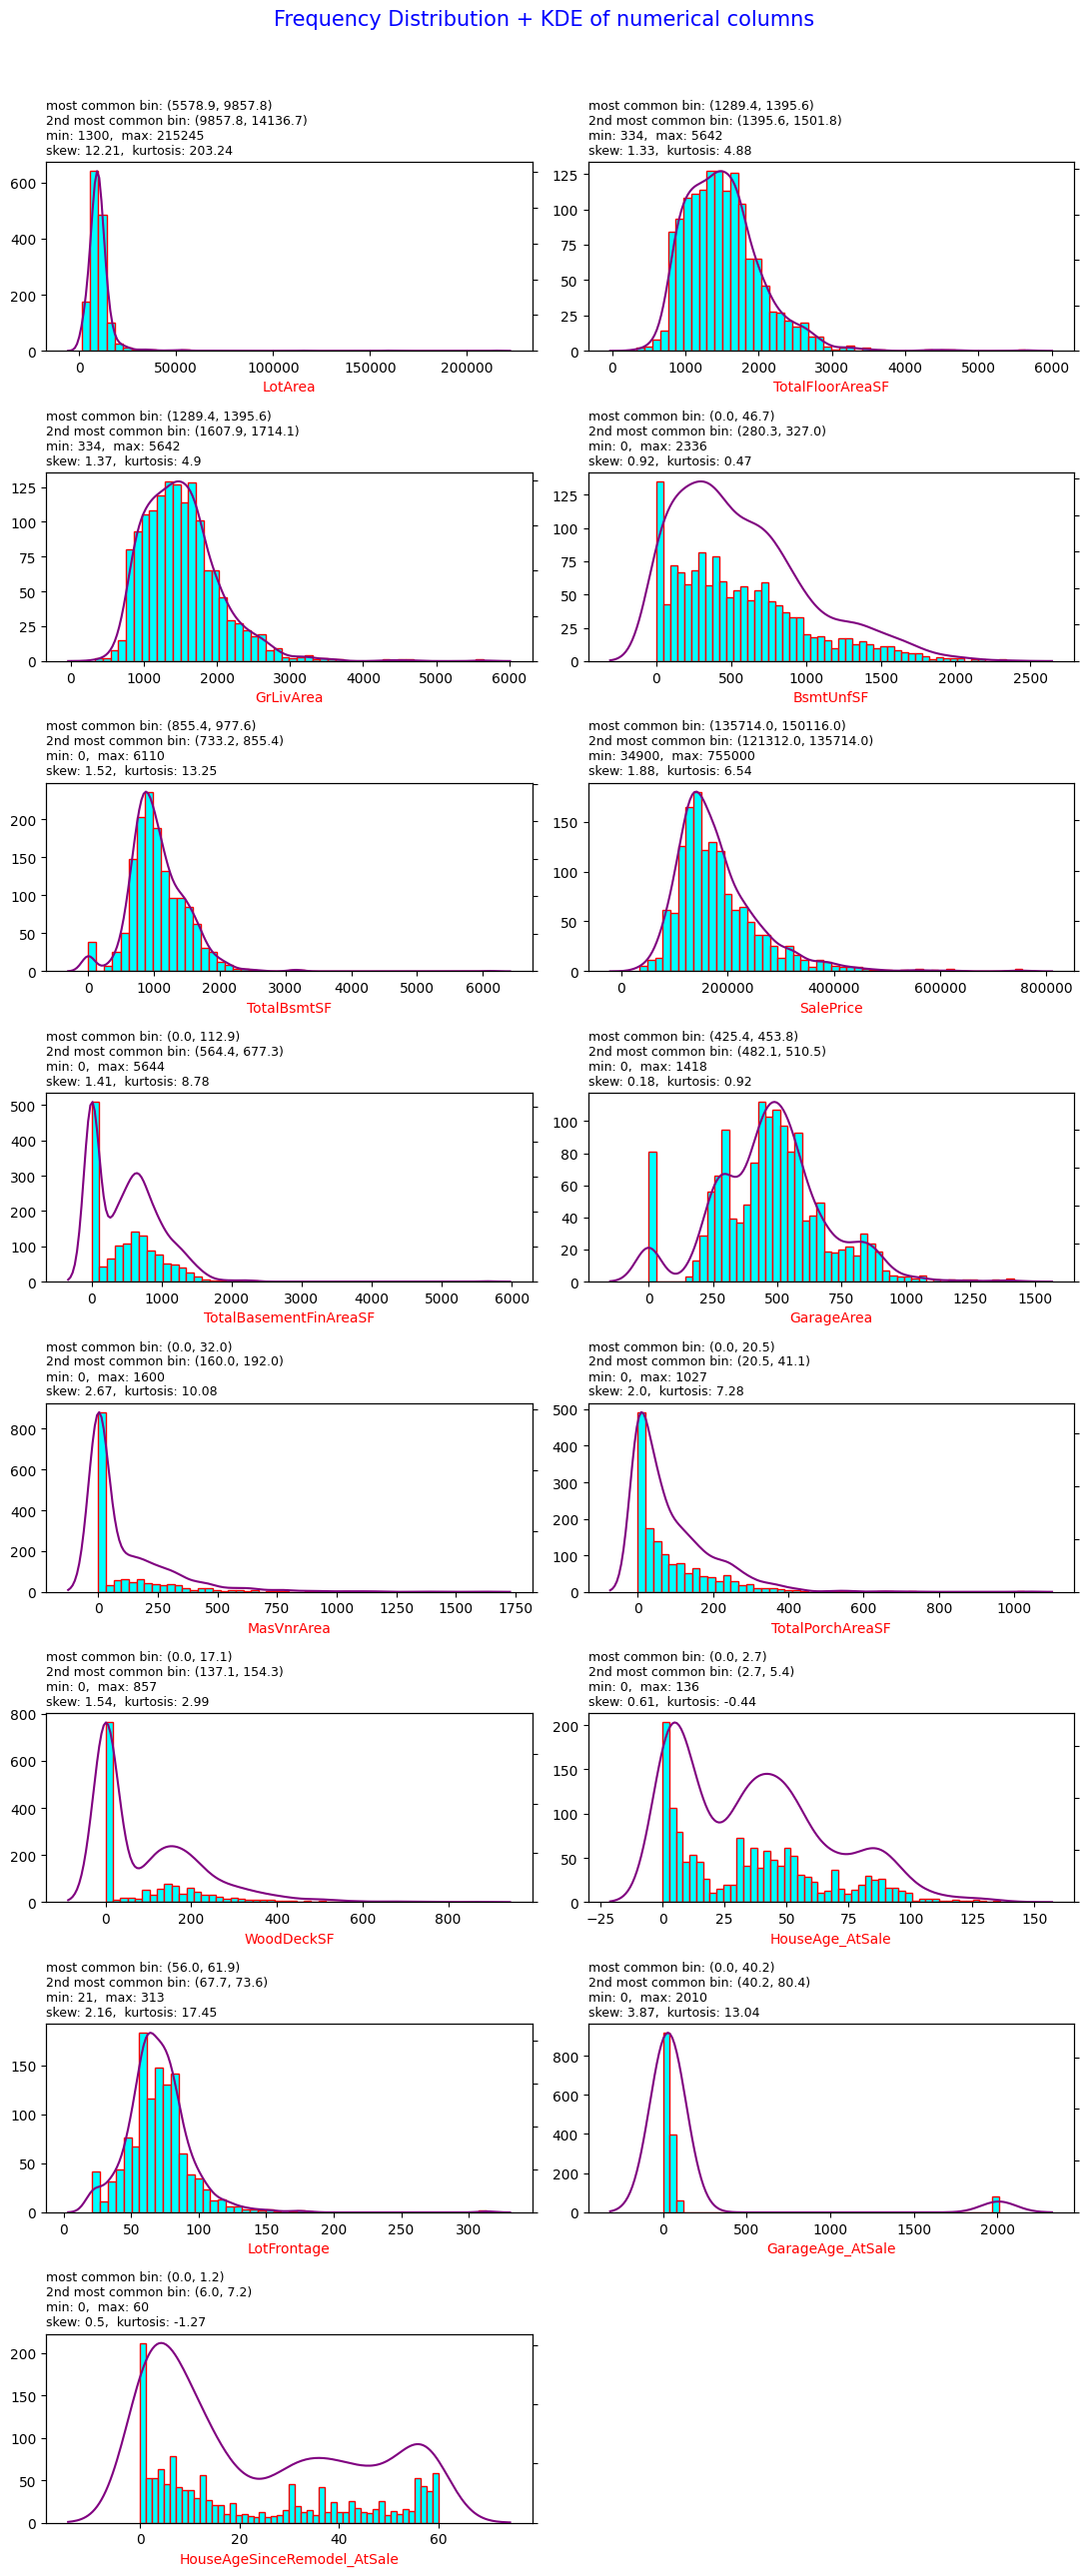

In [26]:
plot_multiple_histograms_univar(house_price_data, top_15_numerical.index.values)

- <span style='color:purple'>Interpretations from above histograms</span>


  - Each variable's minimum and maximum values are shown in the plots, along with the most common bins—that is, the ranges within which most values that are similar fall. 
  
  - Skewness tells us about the asymmetry of the disribution. <br>Kurtosis tells us about the tailedness of the distribution.

  - Extreme values in almost all the variables (except in **HouseAgeSinceRemodel_AtSale**) indicate the presence of <span style='color:blue'><u>outliers</u></span>.

  - **SalePrice** - Consumers typically purchase reasonably priced homes or properties between 120K and 150K AUD. 

  - The majority of sold properties in Australia have **LotArea** between 5000 and 14000 square feet, suggesting that buyers are more inclined to purchase reasonably priced properties with significantly larger lots.

  - **GrLivArea** - Customers find it more comfortable to purchase houses with a living area of between 1000 and 2000 square feet.<br> 
  
  - Buyers want residences with sufficient open areas outside the floor area, especially given the preferred lot sizes.

  - <span style='color:purple'>The combined size of the homes' first and second floors equals the living area above ground.</span> So, we can eliminate the derived metric **TotalFloorAreaSF** from the dataset as it hardly differs from **GrLivArea**. 

  - Unfinished basements are least preferred among buyers as hinted by **BsmtUnfSF**.

  - The ideal basement space **TotalBsmtSF** is roughly 700–1200 square feet, which is less than the total floor area.

  - Real estate buyers appreciate **GarageArea**, even though many do not choose to have them instead. Maybe because they were able to locate parking spots for their automobiles in the lot

  - **MasVnrArea** - Masonry veneer is not present in the majority of the buildings.

  - As is typically the case with home designs, the **TotalPorchAreaSF** of real estate properties that consumers purchase is noticeably smaller in square feet than the total lot size of those properties.

  - **HouseAge_AtSale** & **GarageAge_AtSale** - Newer homes with garages that aren't too ancient are preferred by buyers.

  - **HouseAgeSinceRemodel_AtSale** - Recently refurbished properties are more likely to draw in clients.

4) Drop the derived metric ```TotalFloorAreaSF``` from the dataset as it is found similar to ```GrLivArea``` as explained above 

In [27]:
house_price_data.drop('TotalFloorAreaSF', axis=1, inplace=True)

#### **Detect and Treat Outliers**

1) Create a function to eliminate outliers using Tukey's boxplot method that identifies outliers outside of the range `(q1-1.5*IQR)` and `(q3+1.5*IQR)`

In [28]:
def detect_and_treat_outliers(dframe, exclude_col=''):
    if isinstance(dframe, pd.DataFrame) and isinstance(exclude_col, str):
        for var in dframe.select_dtypes(exclude=object).keys():
            if var not in exclude_col:
                Q1 = dframe[var].quantile(.25)
                Q3 = dframe[var].quantile(.75)
                IQR = Q3-Q1
                dframe = dframe[(dframe[var] >= (Q1-(1.5*IQR))) & (dframe[var] <= (Q3+(1.5*IQR)))]
            return dframe.reset_index(drop=True)
    else:
        raise TypeError('Error: Passed arguments must be dataframe object and/or a column name as a string literal')

2) Execute the above function to remove the outliers

In [29]:
house_price_data = detect_and_treat_outliers(house_price_data, exclude_col='SalePrice')

In [30]:
house_price_data.shape

(1357, 70)

#### **Segmented Univariate Analysis**

1) `YrSold` - It represents the year when the house was sold. Its a categorical feature and so convert it into string type

In [31]:
house_price_data['YrSold'] = house_price_data['YrSold'].astype(str)

2) Examine the property sale prices by <span style='color:blue'>YrSold</span> and <span style='color:blue'>MoSold</span>

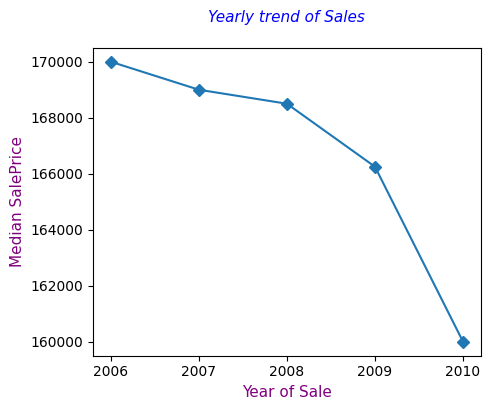

In [32]:
fig = plt.figure()
fig.set_size_inches(w=5, h=4)
plt.plot(house_price_data.groupby('YrSold')['SalePrice'].median(), marker='D')
plt.xlabel('Year of Sale', fontsize=11, fontweight=20, fontstyle='normal', color='purple')
plt.ylabel('Median SalePrice', fontsize=11, fontweight=20, fontstyle='normal', color='purple')
plt.title('Yearly trend of Sales\n', fontsize=11, fontweight=20, fontstyle='oblique', color='blue')
plt.show()

- <span style='color:purple'>Interpretation</span>

  - In general, real estate prices held steady from 2006 and 2008; but, from 2008 onward, there was a significant decrease in demand for real estate, which may have been caused by the collapse of the housing bubble.

In [33]:
house_price_data.groupby('MoSold')['SalePrice'].median()

MoSold
1    160000.000
2    174250.000
3    165250.000
4    151750.000
5    160000.000
6    164900.000
7    170000.000
8    175742.500
9    191000.000
10   160000.000
11   178550.000
12   178500.000
Name: SalePrice, dtype: float64

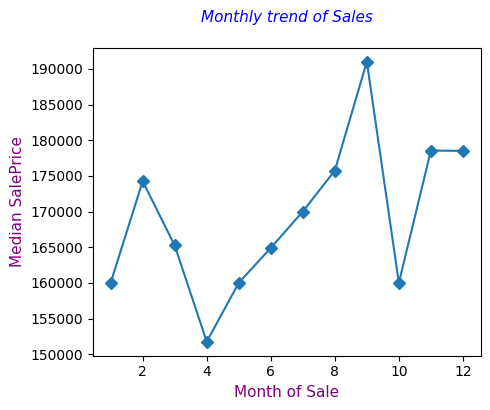

In [34]:
fig = plt.figure()
fig.set_size_inches(w=5, h=4)
plt.plot(house_price_data.groupby('MoSold')['SalePrice'].median().sort_index(level=0), marker='D')
plt.xlabel('Month of Sale', fontsize=11, fontweight=20, fontstyle='normal', color='purple')
plt.ylabel('Median SalePrice', fontsize=11, fontweight=20, fontstyle='normal', color='purple')
plt.title('Monthly trend of Sales\n', fontsize=11, fontweight=20, fontstyle='oblique', color='blue')
plt.show()

- <span style='color:purple'>Interpretation</span>

  - Over the years, the sale price increased dramatically from the fourth to the eighth month. Seem to be a more favorable time frame during which purchasers are more inclined to purchase real estate.

4) `MoSold` - It represents the month when the house was sold. Convert it into string type<br><br>`MSSubClass` - Identifies the type of dwelling involved in the sale, so it is a categorical variable 

In [35]:
house_price_data['MoSold'] = house_price_data['MoSold'].astype(str)
house_price_data['MSSubClass'] = house_price_data['MSSubClass'].astype(str)

5) Analyze the variation in sale prices with respect to other categorical variables.

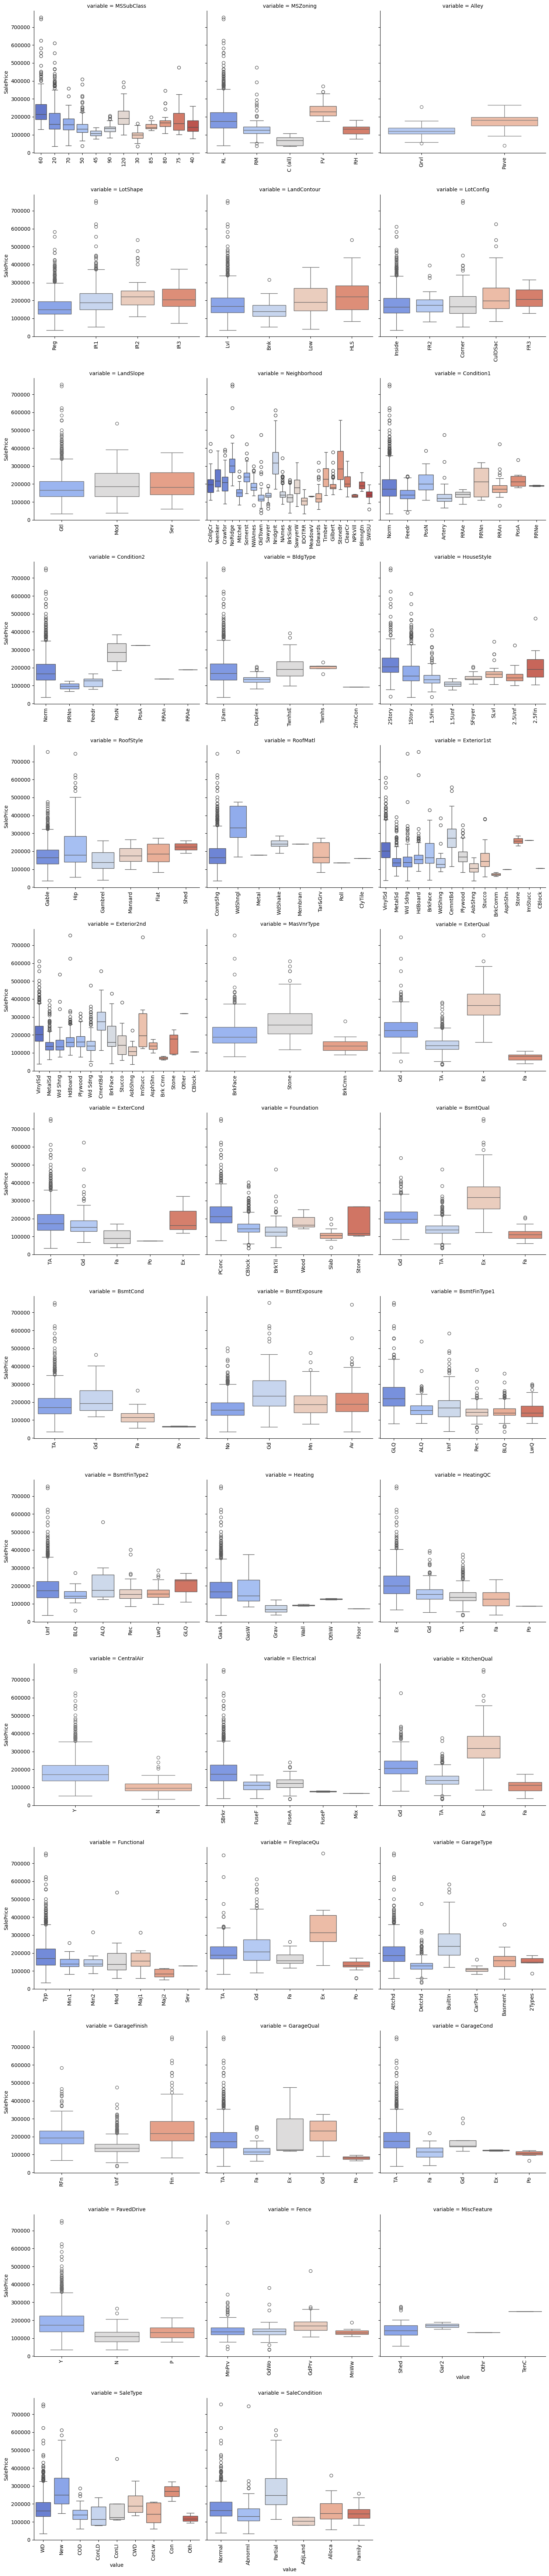

In [36]:
def create_boxplot(x, y, **kwargs):
    sns.boxplot(x=x, y=y, palette='coolwarm')
    plt.xticks(rotation=90)

rem_cat_columns = house_price_data.drop(['MoSold', 'YrSold'], axis=1).select_dtypes(include=object).columns
houseprice_melt_data = house_price_data.melt(id_vars='SalePrice', value_vars= rem_cat_columns)
facet_g = sns.FacetGrid(houseprice_melt_data, col='variable', col_wrap=3, sharex=False, sharey=True, height=5)
facet_g.map(create_boxplot, 'value', 'SalePrice')
fig.tight_layout()

- <span style='color:purple'>Interpretation</span>

  - Alleys, high-quality exteriors, basement height, central air conditioning, and high-quality kitchens significantly impact property prices, attracting buyers with higher demand.

  - The properties' selling prices are influenced by other factors as well, but the variance in sale prices throughout their levels is greater, suggesting that there may be a random element at play. To determine whether the slight difference between the groups is statistically significant and not the result of chance, we might need to do hypothesis testing.

#### **Analysis of quantitative variables to assess their impact on each other and on the target variable <span style='color:purple'>"SalePrice"</span>**

1) <span style='color:green'>Assess impact of numerical variables on SalePrice</span>

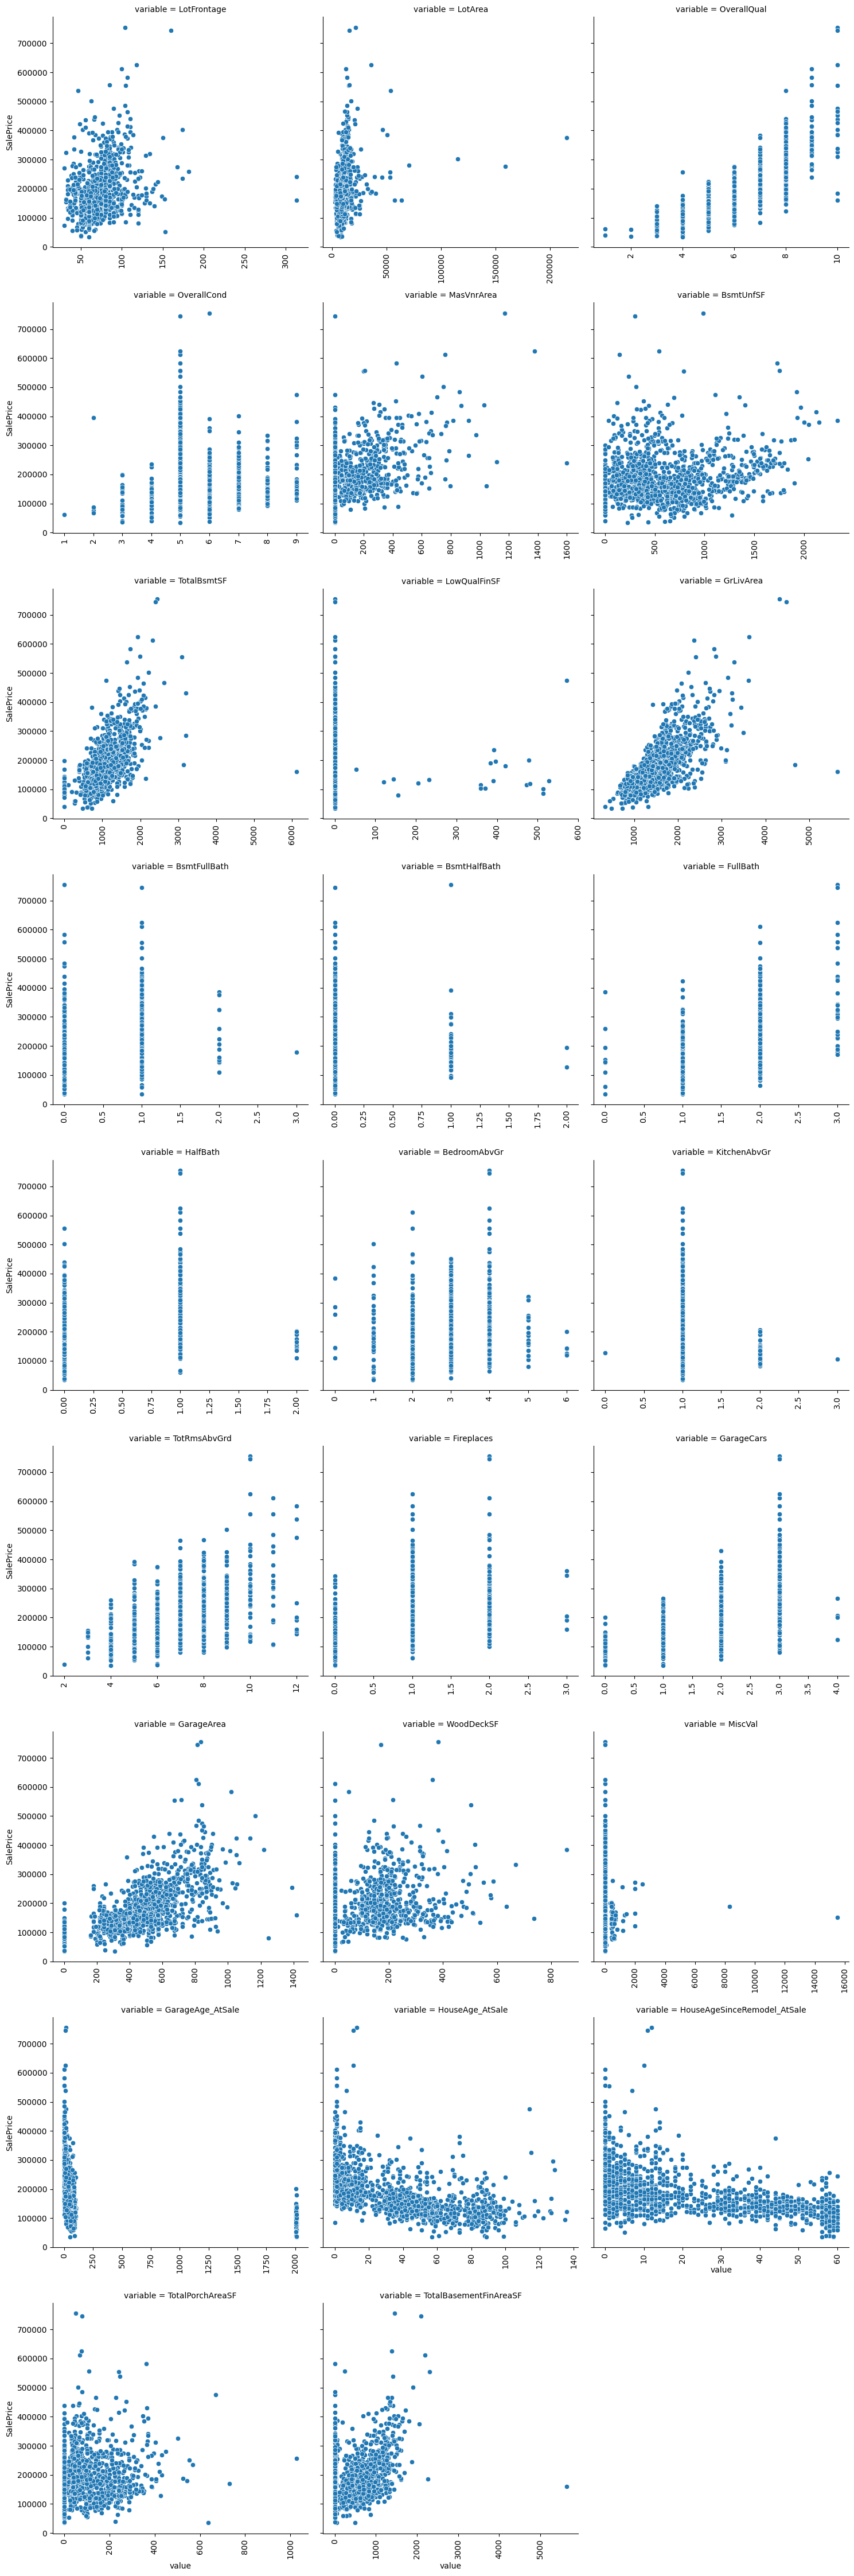

In [37]:
def create_splot(x, y, **kwargs):
    sns.scatterplot(x=x, y=y, palette='coolwarm')
    plt.xticks(rotation=90)

num_columns = house_price_data.select_dtypes(exclude=object).columns
houseprice_melt_data = house_price_data.melt(id_vars='SalePrice', value_vars= num_columns)
facet_g = sns.FacetGrid(houseprice_melt_data, col='variable', col_wrap=3, sharex=False, sharey=True, height=5)
facet_g.map(create_splot, 'value', 'SalePrice')
fig.tight_layout()

- <span style='color:purple'>Interpretation</span>

  - The overall rating **OverallQual** that depends on the material used to contruct the house and its finishing does drive the price of the house

  - As living area increases, so does the cost of buying a property. Hence, **GrLivArea** is highly significant to SalePrice

  - Total square feet of basement area (**TotalBsmtSF**) moderately influence the price of the house

  - Capacity of the Garage (**GarageCars**) or total Garage Area (**GarageArea**) have moderate correlation with SalePrice

2) <span style='color:green'>Heatmap to show Pairwise Correlations of numerical variables</span>

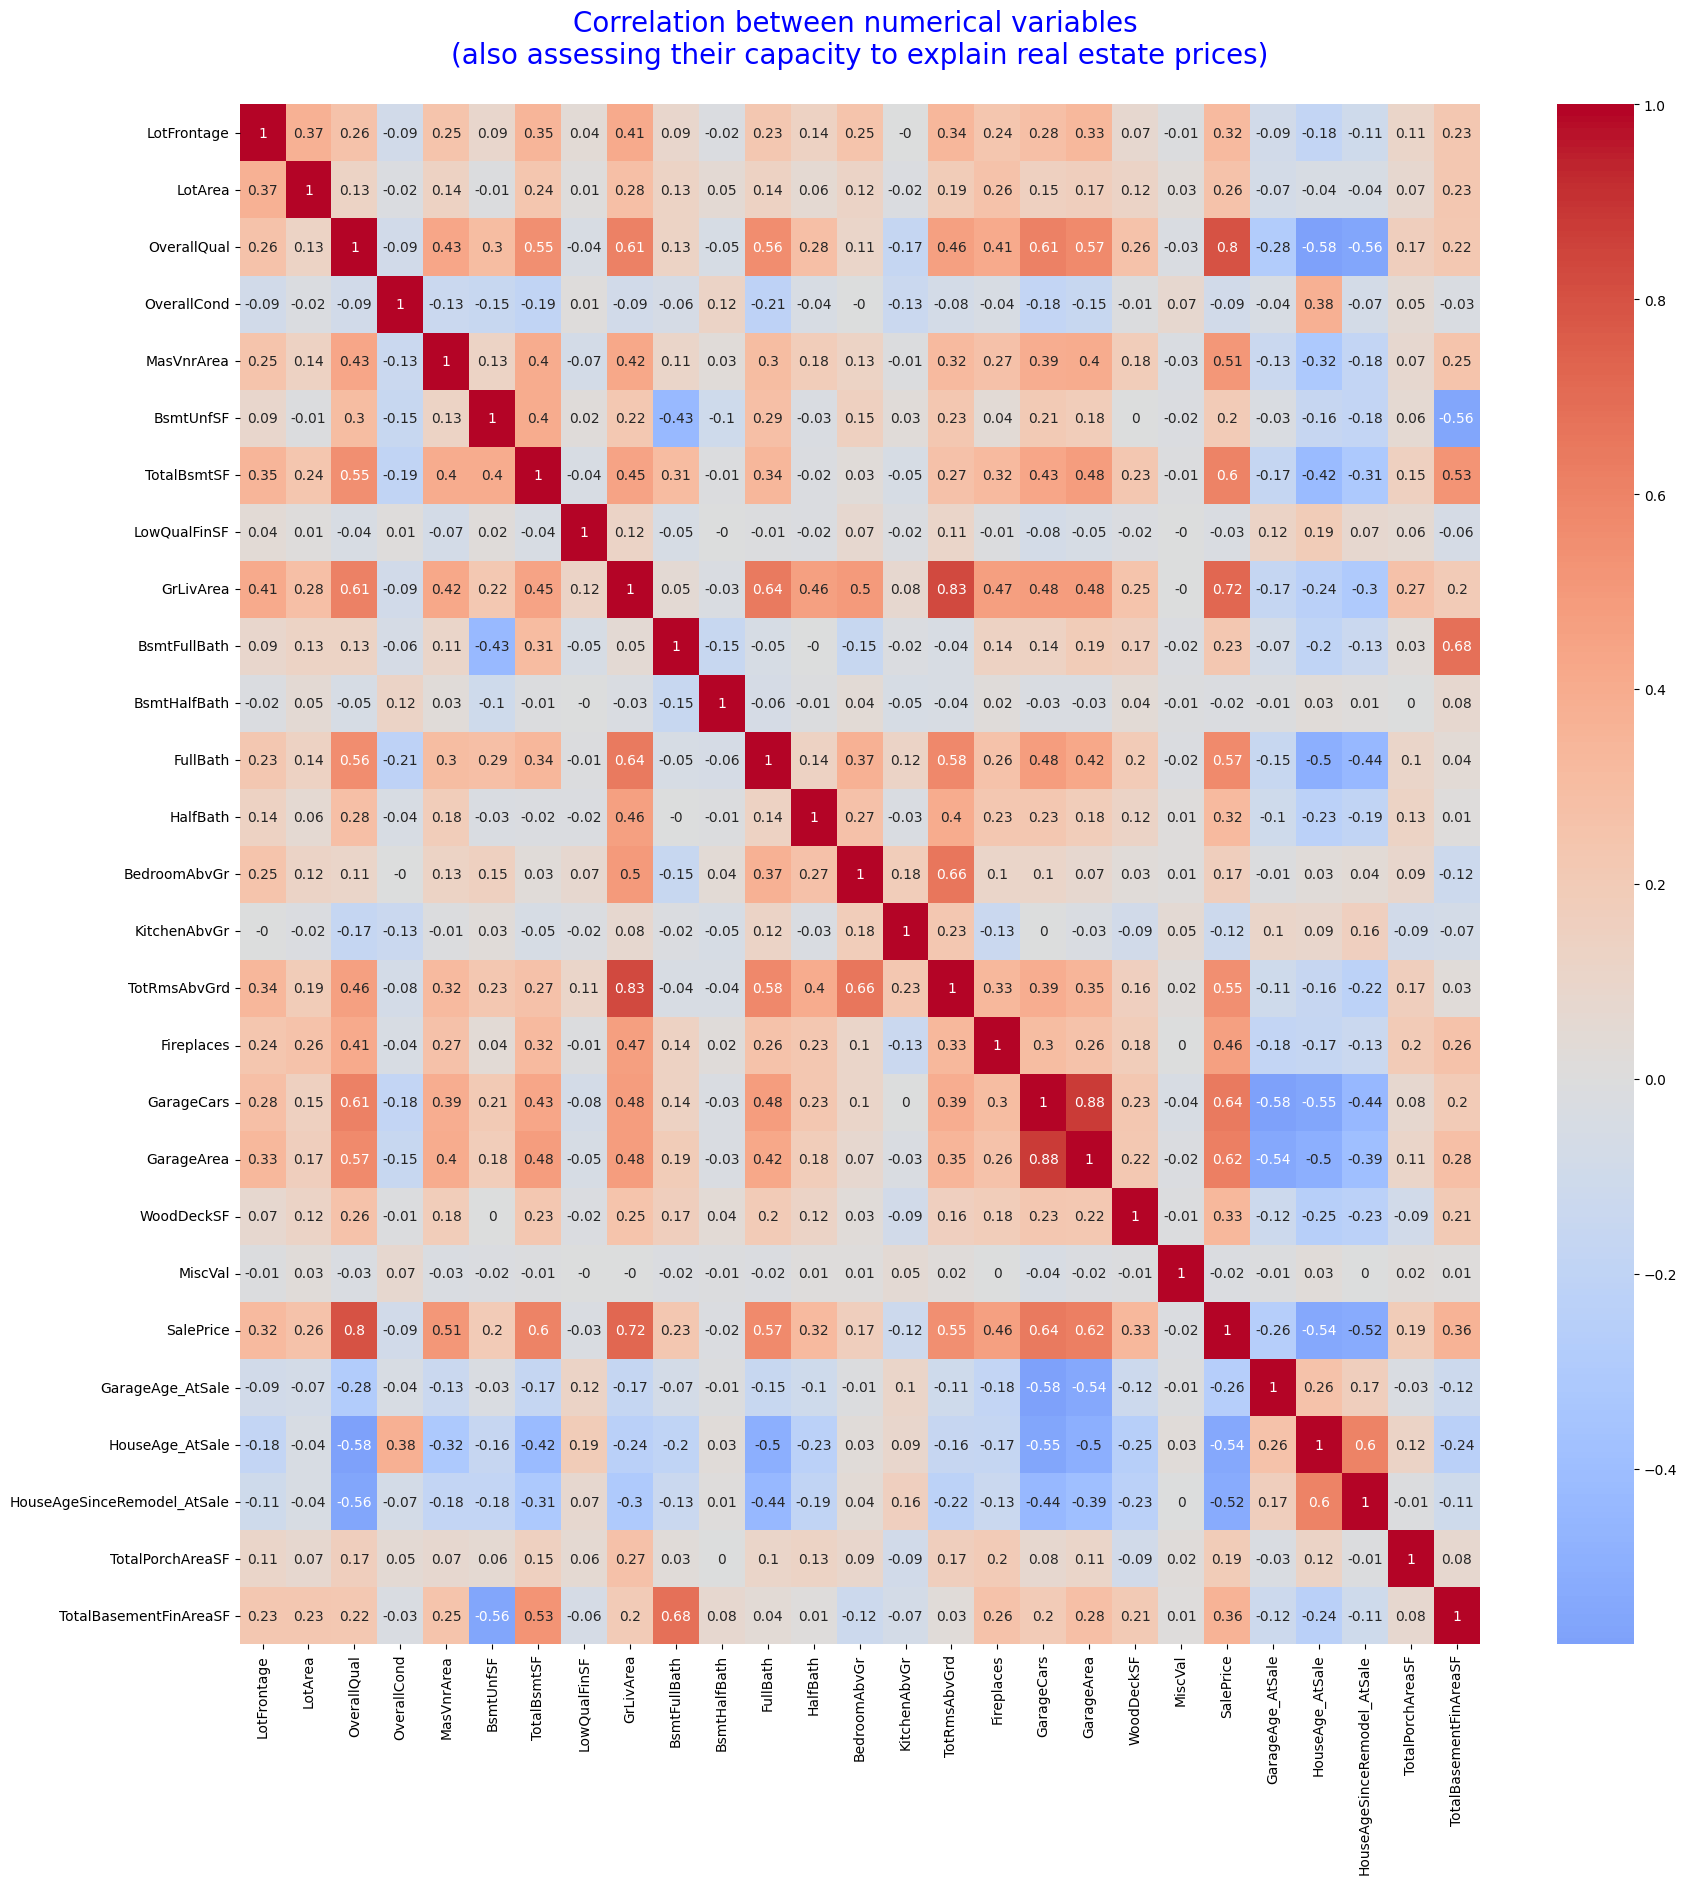

In [38]:
plt.figure(figsize=[20, 20])
sns.heatmap(house_price_data[num_columns].corr().round(2), annot=True, center=0, cmap='coolwarm')
plt.title("Correlation between numerical variables \n(also assessing their capacity to explain real estate prices)\n",
          fontdict=dict(fontsize=20, fontweight=20, color='blue', fontstyle='normal'))
plt.show()

- <span style='color:purple'>Interpretation</span>

  - It is evident that **GarageArea** and **GarageCars** have a significant linear association because garages are typically used for car storage.

  - **OverallQual** & **GarageCars** : <br>Better rated properties command higher rates when they feature garages with ample space for storing cars.

  - **OverallQual** & **GrLivArea** :<br> A house with a larger living area will be valued higher and fetch a higher price.

#### **Data Preparation**

 ```Note```: Outliers were already handled earlier and also ruled out the predictors with 99% of the same values

1) Create dummies for categorical variables

In [39]:
# get dummies for categorical levels. 
df_dummies = pd.get_dummies(house_price_data.select_dtypes(include=object),
                            dtype='int')

# concatenate the dummies to the original dataframe
house_price_data = pd.concat([house_price_data, df_dummies], axis=1, join="inner")

2) Drop the columns for which we have already created dummies of their levels

In [40]:
house_price_data.drop(house_price_data.select_dtypes(include=object).keys(), axis=1, inplace=True)

3) Detect predictors which are correlated to one another

In [41]:
house_price_data_corr_mat = house_price_data.drop('SalePrice', axis=1).corr().abs()
mask = np.tril(np.ones(house_price_data_corr_mat.shape, dtype=bool))
influencers_mat = house_price_data_corr_mat.where(~mask).stack()
influencers_mat = influencers_mat[influencers_mat>=.6]
highly_correlated_predictors = influencers_mat.index.get_level_values(0).unique()

In [42]:
highly_correlated_predictors.shape

(69,)

In [43]:
house_price_data.shape

(1357, 297)

4) Drop the predictors which are correlated to one another to rule out multicolinearity.

In [44]:
house_price_data.drop(highly_correlated_predictors, axis=1, inplace=True)

In [45]:
house_price_data.shape

(1357, 228)

5) Impute missing values

In [46]:
perc_missing = (house_price_data.isna().sum(axis=0)/len(house_price_data)*100).sort_values(ascending=False)
perc_missing[perc_missing>0]

LotFrontage   18.276
MasVnrArea     0.590
dtype: float64

In [47]:
# missing value imputation
house_price_data['MasVnrArea'] = house_price_data['MasVnrArea'].fillna(0)
house_price_data['LotFrontage'] = house_price_data['LotFrontage'].fillna(0)

#### **Splitting the data into Training and Testing sets**

  - <span style='color:purple'>70%</span> of the data will be taken into the <span style='color:purple'>training set</span> and the remaining <span style='color:blue'>30%</span> will be taken into <span style='color:blue'>test set</span>

In [48]:
X = house_price_data.drop('SalePrice',axis=1)
y = house_price_data['SalePrice']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)

In [49]:
print(f'Shape of the training dataset: {X_train.shape}')
print(f'Shape of the testing dataset: {X_test.shape}')

Shape of the training dataset: (949, 227)
Shape of the testing dataset: (408, 227)


#### **Rescaling the columns using MinMaxScaler class from sklearn**

In [50]:
# instantiate the MinMaxScalar class
scaler = MinMaxScaler()

# rescale the columns
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

#### **Apply transformation to target variable so that it can follow a normal distribution**

In [51]:
power_transformer = PowerTransformer(method='box-cox', standardize=False)
y_train = power_transformer.fit_transform(y_train.to_frame())
y_test = power_transformer.transform(y_test.to_frame())

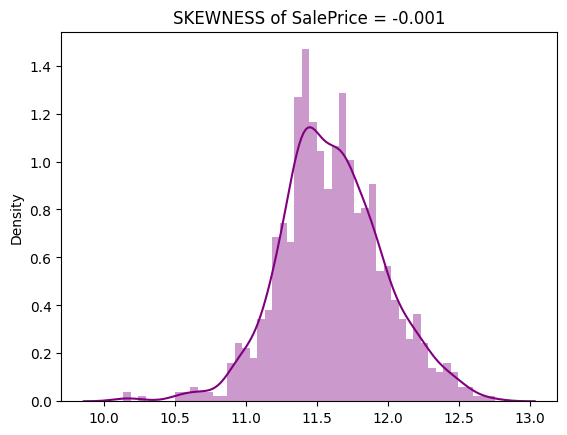

In [52]:
sns.distplot(y_train, bins=50, kde=True, color='purple')
plt.title(f'SKEWNESS of SalePrice = {round(stats.skew(y_train)[0], 3)}')
plt.show()

- <span style='color:blue'>Interpretation</span>
  
  - Target variable is normally ditributed 

#### **Build a Ridge Regression model which will regress on the RFE supported predictors**

In [53]:
# list of hyperparameters to tune
grid_params = {'alpha': [1.0, 2.0, 3.0, 4.0, 5.0, 5.1, 5.2, 5.3, 5.4, 5.5, 5.6, 5.7, 5.8, 5.9, 
                         6.0, 6.1, 6.2, 6.3, 6.4, 7.0, 8.0, 9.0, 10.0]}
ridge = Ridge(random_state=100)

# Using RFE to find top 200 variables
rfe = RFE(estimator=Ridge(), n_features_to_select=200)
rfe = rfe.fit(X_train,y_train)
rfe_selected_col = X_train.columns[rfe.support_]
X_train_rfe = X_train[rfe_selected_col]
X_test_rfe = X_test[rfe_selected_col]

# Hyperparamter tuning using GrishSearchCV
folds = 10
model_cv = GridSearchCV(estimator = ridge, param_grid = grid_params, scoring= 'r2', cv = folds, return_train_score=True, verbose = 1)            
model_cv.fit(X_train_rfe, y_train)

cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results = cv_results[cv_results['param_alpha']<=30]
cv_results['param_alpha'] = cv_results['param_alpha'].astype(int)

Fitting 10 folds for each of 23 candidates, totalling 230 fits


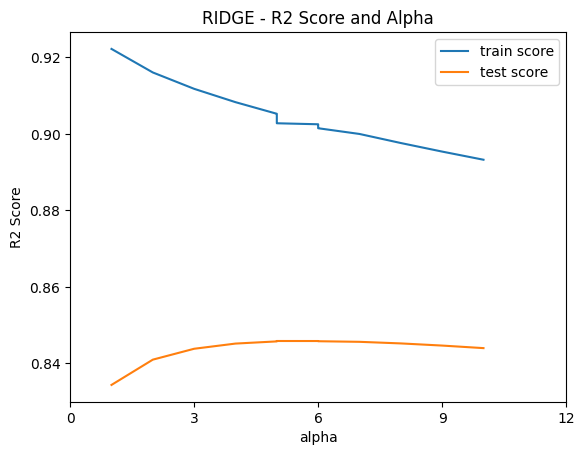

RIDGE - Best alpha is 5
RIDGE - R2 Score of the model on the TRAIN set 0.9038658888855342
RIDGE - R2 Score on the TEST set 0.8452692094712341
RIDGE - Mean Squared Error on the TEST set 0.02300223653636021 


Coefficients associated to predictors of Final Ridge Model


,Ridge Coef
TotRmsAbvGrd,0.248
GarageArea,0.219
TotalBsmtSF,0.190
FullBath,0.171
Neighborhood_NoRidge,0.157
Neighborhood_StoneBr,0.137
Neighborhood_NridgHt,0.122
OverallCond,0.122
TotalPorchAreaSF,0.108
Neighborhood_Crawfor,0.104


In [54]:
plt.plot(cv_results['param_alpha'], cv_results['mean_train_score'])
plt.plot(cv_results['param_alpha'], cv_results['mean_test_score'])
plt.xlabel('alpha')
plt.ylabel('R2 Score')
plt.title("RIDGE - R2 Score and Alpha")
plt.legend(['train score', 'test score'])
plt.xticks(np.arange(0,15,3))
plt.show()

ridge_alpha = cv_results['param_alpha'].loc[cv_results['mean_test_score'].idxmax()]
print('RIDGE - Best alpha is',ridge_alpha)
ridge_final = Ridge(alpha=ridge_alpha, random_state=100)
ridge_final.fit(X_train_rfe,y_train)
ridge_coef = ridge_final.coef_.reshape(1, -1)
df_ridge_coef = pd.DataFrame(ridge_coef, columns=X_train_rfe.columns).T
df_ridge_coef.columns = ['Ridge Coef']
df_ridge_coef.sort_values(by='Ridge Coef', ascending=False, inplace=True)
y_test_pred = ridge_final.predict(X_test_rfe)
y_train_pred = ridge_final.predict(X_train_rfe)
print('RIDGE - R2 Score of the model on the TRAIN set',r2_score(y_train, y_train_pred))
print('RIDGE - R2 Score on the TEST set',r2_score(y_test, y_test_pred))
print('RIDGE - Mean Squared Error on the TEST set', mean_squared_error(y_test, y_test_pred), '\n\n')
print('Coefficients associated to predictors of Final Ridge Model')
df_ridge_coef.head(20)

#### **Residual Analysis for Final Ridge model on the training data**

1) Check whether the error terms meet the assumption of normality

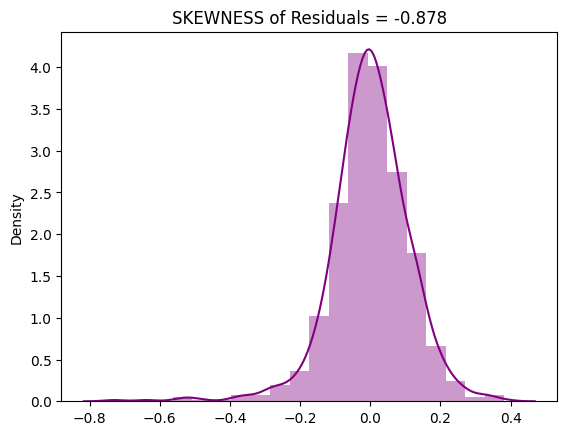

In [55]:
y_train_pred = ridge_final.predict(X_train_rfe)
residuals = y_train - y_train_pred
sns.distplot(residuals, bins=20, color='purple')
plt.title(f'SKEWNESS of Residuals = {round(stats.skew(residuals)[0], 3)}')
plt.show()

- <span style='color:green'>**Interpretation**</span>

  - Error Terms are normally distributed, with mean = 0

#### **Build a Lasso Regression model which will regress on the predictors from X_train**

Fitting 10 folds for each of 9 candidates, totalling 90 fits


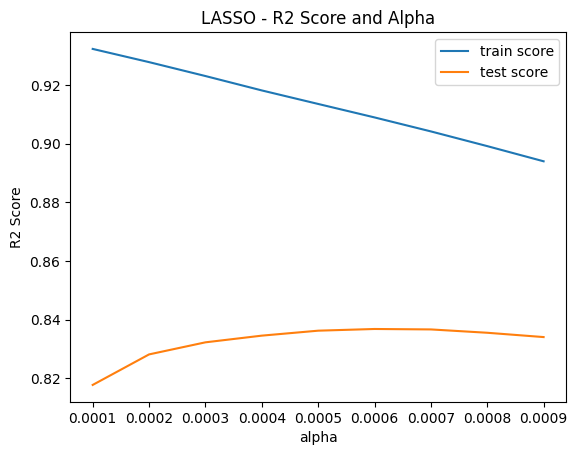

LASSO - Best alpha is 0.0006
LASSO - R2 Score on the TRAIN set 0.9057080988065296
LASSO - R2 Score on the TEST set 0.8669831134058027
LASSO - Mean Squared Error on the TEST set 0.019774253581423436 


Coefficients associated to predictors of Final Lasso Model


,Lasso Coef
TotalBsmtSF,0.740
TotRmsAbvGrd,0.306
GarageArea,0.297
OverallCond,0.168
FullBath,0.149
Neighborhood_NoRidge,0.142
Neighborhood_StoneBr,0.137
Neighborhood_Crawfor,0.128
Neighborhood_NridgHt,0.112
CentralAir_Y,0.110


In [56]:
# Hyperparameters
grid_params = {'alpha': [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008, 0.0009]}
lasso = Lasso(random_state=100)

# Tuning of Hyperparams
folds = 10
model_cv = GridSearchCV(estimator = lasso, param_grid = grid_params, scoring= 'r2', cv = folds, return_train_score=True, verbose = 1)            
model_cv.fit(X_train_rfe, y_train) 

cv_results = pd.DataFrame(model_cv.cv_results_)
plt.plot(cv_results['param_alpha'], cv_results['mean_train_score'])
plt.plot(cv_results['param_alpha'], cv_results['mean_test_score'])
plt.xlabel('alpha')
plt.ylabel('R2 Score')
plt.title("LASSO - R2 Score and Alpha")
plt.legend(['train score', 'test score'], loc='upper right')
plt.show()

lasso_alpha = cv_results['param_alpha'].loc[cv_results['mean_test_score'].idxmax()]
print('LASSO - Best alpha is',lasso_alpha)
lasso_final = Lasso(alpha=lasso_alpha, random_state=100)
lasso_final.fit(X_train_rfe,y_train)
lasso_coef = lasso_final.coef_.reshape(1, -1)
df_lasso_coef = pd.DataFrame(lasso_coef, columns=X_train_rfe.columns).T
df_lasso_coef.columns = ['Lasso Coef']
df_lasso_coef.sort_values(by='Lasso Coef', ascending=False, inplace=True)
y_test_pred = lasso_final.predict(X_test_rfe)
y_train_pred = lasso_final.predict(X_train_rfe)
print('LASSO - R2 Score on the TRAIN set',r2_score(y_train, y_train_pred))
print('LASSO - R2 Score on the TEST set',r2_score(y_test, y_test_pred))
print('LASSO - Mean Squared Error on the TEST set', mean_squared_error(y_test, y_test_pred), '\n\n')
print('Coefficients associated to predictors of Final Lasso Model')
df_lasso_coef.head(20)

#### **Residual Analysis for Final Lasso model on the training data**

1) Check whether the error terms meet the assumption of normality

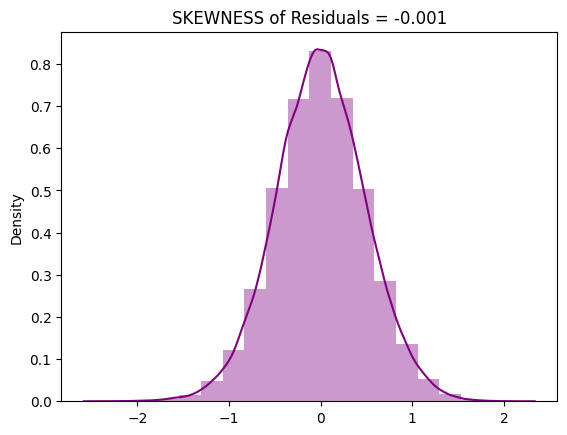

In [57]:
y_train_pred = lasso_final.predict(X_train_rfe)
residuals = y_train - y_train_pred
sns.distplot(residuals, bins=20, color='purple')
plt.title(f'SKEWNESS of Residuals = {round(stats.skew(residuals)[0], 3)}')
plt.show()

- <span style='color:green'>**Interpretation**</span>

  - Error Terms are normally distributed, with mean = 0

<span style="color:blue">**Top 6 Influencers** that are more likely to influence SalePrice</span>

- **TotalBsmtSF**
- **TotRmsAbvGrd**
- **GarageArea** 
- **OverallCond** 
- **FullBath**
- **Neighborhood_NoRidge**

<span style="color:blue">**R2** Score on test set</span>

- ***For Ridge Regression model, R2 Score is 0.84***

- ***For Lasso Regression model, R2 score is 0.86***

#### <span style="color:blue">**For Subjective Questions**</span>

1) Building Ridge Model - Double the value of alpha

In [58]:
ridge_model_subjective = Ridge(alpha=ridge_alpha*2,random_state=100)
ridge_model_subjective.fit(X_train_rfe,y_train)
ridge_model_subjective_coef = ridge_model_subjective.coef_.reshape(1, -1)
y_test_pred = ridge_model_subjective.predict(X_test_rfe)
df_ridge_coef2 = pd.DataFrame(ridge_model_subjective_coef, columns=X_test_rfe.columns).T
df_ridge_coef2.columns = ['Ridge Coef - DOUBLE ALPHA']
df_ridge_coef2.sort_values(by='Ridge Coef - DOUBLE ALPHA', ascending=False, inplace=True)
print('RIDGE - R2 Score on test set',r2_score(y_test, y_test_pred))
print('RIDGE - Mean Squared Error on test set', mean_squared_error(y_test, y_test_pred), '\n\n')
print('Top Influencers derived from Ridge After Doubling the value of alpha:')
df_ridge_coef2.head(20)

RIDGE - R2 Score on test set 0.8386323753980807
RIDGE - Mean Squared Error on test set 0.023988866454565584 


Top Influencers derived from Ridge After Doubling the value of alpha:


,Ridge Coef - DOUBLE ALPHA
TotRmsAbvGrd,0.218
GarageArea,0.184
FullBath,0.162
Neighborhood_NoRidge,0.138
TotalBsmtSF,0.135
Neighborhood_StoneBr,0.110
Neighborhood_NridgHt,0.103
OverallCond,0.095
Neighborhood_Crawfor,0.095
CentralAir_Y,0.094


2) Building Lasso Model - Double the value of alpha

In [59]:
lasso_model_subjective = Lasso(alpha=lasso_alpha*2,random_state=100)
lasso_model_subjective.fit(X_train_rfe,y_train)
lasso_model_subjective_coef = lasso_model_subjective.coef_.reshape(1, -1)
y_test_pred = lasso_model_subjective.predict(X_test_rfe)
df_lasso_coef2 = pd.DataFrame(lasso_model_subjective_coef, columns=X_train_rfe.columns).T
df_lasso_coef2.columns = ['Lasso Coef - DOUBLE ALPHA']
df_lasso_coef2.sort_values(by='Lasso Coef - DOUBLE ALPHA', ascending=False, inplace=True)
print('LASSO - R2 Score on test set',r2_score(y_test, y_test_pred))
print('LASSO - Mean Squared Error on test set', mean_squared_error(y_test, y_test_pred), '\n\n')
print('Top Influencers derived from Lasso After Doubling the value of alpha:')
df_lasso_coef2.head(20)

LASSO - R2 Score on test set 0.8522632252305373
LASSO - Mean Squared Error on test set 0.021962508087453873 


Top Influencers derived from Lasso After Doubling the value of alpha:


,Lasso Coef - DOUBLE ALPHA
TotRmsAbvGrd,0.339
TotalBsmtSF,0.315
GarageArea,0.285
FullBath,0.179
Neighborhood_NoRidge,0.149
OverallCond,0.128
Neighborhood_Crawfor,0.119
Neighborhood_StoneBr,0.116
CentralAir_Y,0.110
Neighborhood_NridgHt,0.105


After building the model, you realised that the five most important predictor variables in the lasso model are not available in the incoming data. You will now have to create another model excluding the five most important predictor variables. Which are the five most important predictor variables now?

In [60]:
# Dropping the top 5 important predictor variables
X_test_rfe_new = X_test_rfe.drop(['TotalBsmtSF','TotRmsAbvGrd','GarageArea','OverallCond','FullBath'],axis=1)
X_train_rfe_new = X_train_rfe.drop(['TotalBsmtSF','TotRmsAbvGrd','GarageArea','OverallCond','FullBath'],axis=1)

In [61]:
# creating new lasso model
lasso_model_subjective_new = Lasso(alpha=lasso_alpha,random_state=100)
lasso_model_subjective_new.fit(X_train_rfe_new,y_train)
lasso_model_subjective_new_coef = lasso_model_subjective_new.coef_.reshape(1, -1)
y_test_pred = lasso_model_subjective_new.predict(X_test_rfe_new)
df_lasso_coef_new = pd.DataFrame(lasso_model_subjective_new_coef, columns=X_train_rfe_new.columns).T
df_lasso_coef_new.columns = ['Lasso Coef For Subjective Question 3']
df_lasso_coef_new.sort_values(by='Lasso Coef For Subjective Question 3', ascending=False, inplace=True)
print('LASSO - R2 Score on test set',r2_score(y_test, y_test_pred))
print('LASSO - Mean Squared Error on test set', mean_squared_error(y_test, y_test_pred), '\n\n')
print('Top Influencers derived from Lasso For Subjective Question 3:')
df_lasso_coef_new[:5]

LASSO - R2 Score on test set 0.7983105910968706
LASSO - Mean Squared Error on test set 0.02998309175965831 


Top Influencers derived from Lasso For Subjective Question 3:


,Lasso Coef For Subjective Question 3
Neighborhood_NoRidge,0.205
LotArea,0.185
Neighborhood_StoneBr,0.180
TotalPorchAreaSF,0.156
Neighborhood_NridgHt,0.155
